# OPM Example (Parcel Level)

Start-to-end example script for applying the canonical HMM to OPM data.

#### Input Data

We will use data in BIDS format:
```
BIDS/
├── ...
├── sub-05/
│   ├── meg/
│   │   ├── sub-05_ses-01_task-braille_run-01_meg.fif
│   │   ├── ...
│   ├── anat/
│   │   ├── sub-05_T1w.nii
│   │   └── ...
├── ...
```
And write output to the `BIDS/derivatives` directory.

#### Steps

1. Preprocessing:
    - We clean the sensor-level OPM data and save the output to `BIDS/derivatives/preprocessed`.

2. Surface Extraction:
    - We will extract surfaces using FSL from a structural MRI and save to `BIDS/derivatives/anat_surfaces`.

3. Coregistration:
    - We will coregister the OPM and with structural MRI using headshape points/fiducials from an EinScan and the surfaces from the MRI.
    - We will also compute the forward model.

4. Source Reconstruction (LCMV Beamformer):
    - We will compute a volumetric LCMV beamformer and apply it to the cleaned sensor data to get data in a voxel grid.

5. Parcellation:
    - We will parcel the data and orthogonalise to remove spatial leakage.
    - The output of steps 2-5 will be saved to `BIDS/derivatives/osl`.

6. Prepare Data for the Canonical HMM:
    - We will perform dipole sign flipping, time-delay embedding, PCA and standardisation to prepare the parcel data for the canonical HMM.

7. Fit the Canonical HMM:
    - We will apply the canonical HMM to the prepared data.

8. HMM Post-Hoc Analysis:
    - Estimate state-specific quantities of interest, such as spectral properties, networks, and summary statistics for dynamics.
    - The output will be saved to `BIDS/derivatives/hmm`.

 Although we provide a single start-to-end example script, it is possible to separate the different steps. E.g. you may wish to do all the preprocessing (for different sessions) in a script then have a separate script for the coregistration, source reconstruction and parcellation, as well as a different script for the HMM.

#### Import Packages

In [1]:
import os
import numpy as np
from pathlib import Path

import mne
mne.viz.set_3d_backend("notebook")

from modules import preproc, rhino, source_recon, parcellation, hmm, utils

from osl_dynamics import inference, analysis
from osl_dynamics.utils import plotting
from osl_dynamics.data import Data

Using notebook 3d backend.


2026-01-19 19:39:22.894847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Session Info

Let's specify which session in the `BIDS` directory we wish to study.

In [2]:
subject = "05"
session = "01"
task = "braille"
run = "01"
id = f"sub-{subject}_ses-{session}_task-{task}_run-{run}"
print("id:", id)

id: sub-05_ses-01_task-braille_run-01


## 1. Preprocessing

Now, we can clean the sensor data. We will use MNE to do this. Let's load the raw fif file.

In [3]:
raw_file = f"BIDS/sub-{subject}/meg/{id}_meg.fif"
raw = mne.io.read_raw_fif(raw_file, preload=True)

Opening raw data file BIDS/sub-05/meg/sub-05_ses-01_task-braille_run-01_meg.fif...
    Range : 0 ... 502399 =      0.000 ...  1339.731 secs
Ready.
Reading 0 ... 502399  =      0.000 ...  1339.731 secs...


Now, let's perform some minimal preprocessing: filtering, downsampling and bad segment/channel detection.

In [4]:
raw = raw.filter(l_freq=4, h_freq=40, method="iir", iir_params={"order": 5, "ftype": "butter"})
raw = raw.resample(sfreq=250)
raw = preproc.detect_bad_segments(raw, picks="mag", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="mag", mode="diff", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="mag", metric="kurtosis", significance_level=0.1)
raw = preproc.detect_bad_channels(raw, mode="psd", picks="mag", significance_level=0.1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Finding events on: A1, bra-0, A3, Rig, A5, A6, A7, A8, bra-1, A10, bra-2, A12, Lef, A14, Bra, A16, T1, key, T3, T4, T5, T6, T7, T8, T9, T10, T11
12817 events found on stim channel bra-0
Event IDs: [1 2]
Finding events on: A1, bra-0, A3, Rig, A5, A6, A7, A8, bra-1, A10, bra-2, A12, Lef, A14, Bra, A16, T1, key, T3, T4, T5, T6, T7, T8, T9, T10, T11
11894 events found on stim channel bra-0
Event IDs: [2]
40 events found on stim channel Rig
Event IDs: [3]
779 events found on stim channel bra-1
Event IDs: [2]
655 events found on stim channel bra-2
Event IDs: [1 2]

Bad segment detection
---------------------
Modality: mag
Mode: None
Metric: std
Significance level: 0.1
Maximum fraction

/Users/gohil/packages/miniforge3/envs/osld/lib/python3.12/site-packages/mne/time_frequency/psd.py:291: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/Users/gohil/packages/miniforge3/envs/osld/lib/python3.12/site-packages/mne/time_frequency/psd.py:291: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/Users/gohil/packages/miniforge3/envs/osld/lib/python3.12/site-packages/mne/time_frequency/psd.py:291: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/Users/gohil/packages/miniforge3/envs/osld/lib/python3.12/site-packages/mne/time_frequency/psd.py:291: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/Users/gohil/packages/miniforge3/envs/osld/lib/python3.12/site-packages/mne/time_frequency/psd.py:291: UserWarning: nper

4 bad channels:
['A6X', 'E3X', 'A8Z', 'B8Z']


/Users/gohil/Desktop/Canonical-HMM-Networks/modules/preproc.py:284: RuntimeWarning: invalid value encountered in scalar divide
  R[j] = R[j] / np.nanstd(temp)


One of the major differences when working with data from the CERCA Magnetics system is the inclusion of headshape data from the handheld 3D EinScan. This usually gives a very dense mesh of the head, face, and neck. A lot of the points are redundant (making the ICP algorithm we will use in coregistration more likely to get stuck in local minima) and some parts of the mesh don’t line up with a typical structural MRI. To get around this, we can use the `decimate_headshape_points` function to reduce the density of the mesh.

Note, this function has a lot of keyword arguments that has default values that work well for adults when the fiducials are placed correctly. However, the default keyword arguments can be less reliable for children with smaller heads. See the source code for the function in `modules/preproc` for a list of the keyword arguments.

In [5]:
raw = preproc.decimate_headshape_points(raw)


Decimate headshape points
-------------------------
Digitization points: (4786, 3)
Removing points below zlim
Using gridaverage


And finally we save the preprocessed data.

In [6]:
preproc_file = Path(f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif")
preproc_file.parent.mkdir(parents=True, exist_ok=True)
raw.save(preproc_file, overwrite=True)

Overwriting existing file.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-05_ses-01_task-braille_run-01_preproc-raw.fif
Overwriting existing file.
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-05_ses-01_task-braille_run-01_preproc-raw.fif
[done]


[PosixPath('/Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-05_ses-01_task-braille_run-01_preproc-raw.fif')]

## 2. Surface Extraction

First we extract surfaces (inskull, outskull and outskin) from the structural MRI. Note, if you do not have a structural MRI we can skip this step and use a standard (MNI152) brain (see below).


Extracting surfaces
-------------------
You can use the following command line call to check the MRI is appropriate, including checking that the L-R, S-I, A-P labels are sensible:
fsleyes BIDS/derivatives/anat_surfaces/sub-05/smri.nii.gz /Users/gohil/packages/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz
Running BET pre-FLIRT...
Running FLIRT...
Running BET and BETSURF...
Refining scalp surface...
Adding nose to scalp surface...
Overwriting existing file.
Overwriting existing file.
Cleaning up FLIRT files
Saving BIDS/derivatives/anat_surfaces/sub-05/inskull.png
Saving BIDS/derivatives/anat_surfaces/sub-05/outskull.png
Saving BIDS/derivatives/anat_surfaces/sub-05/outskin.png
Saving BIDS/derivatives/anat_surfaces/sub-05/outskin_plus_nose.png
Surface extraction complete.


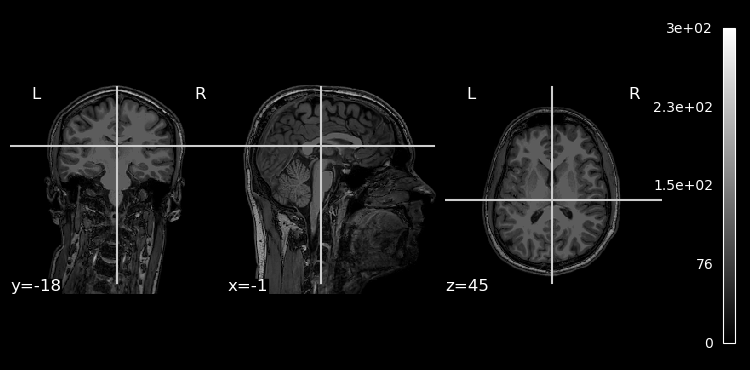

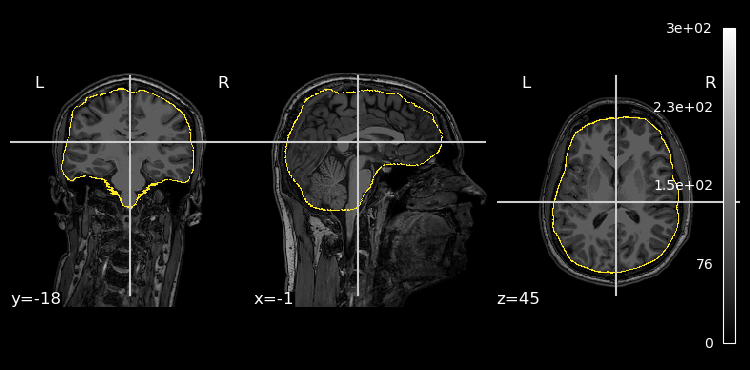

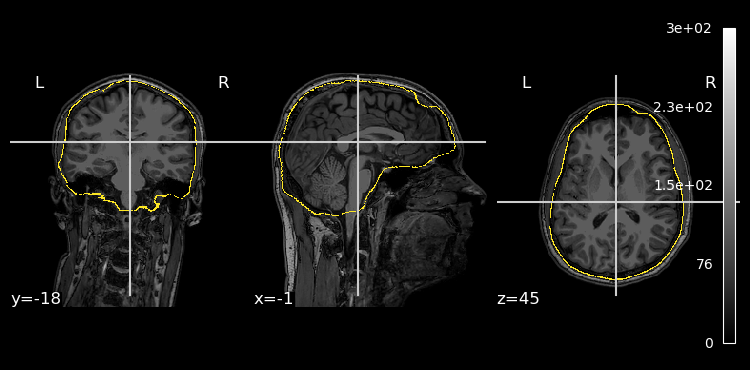

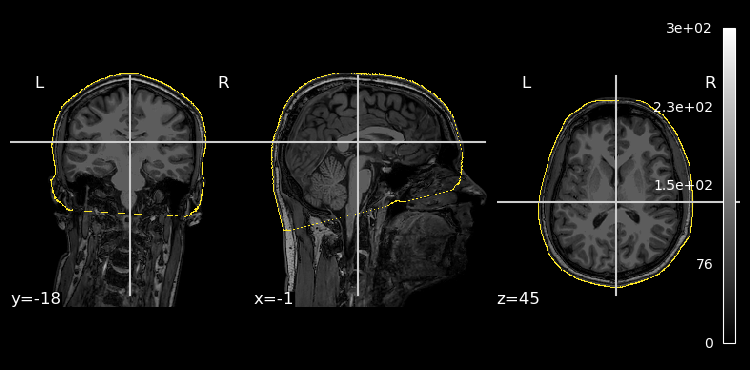

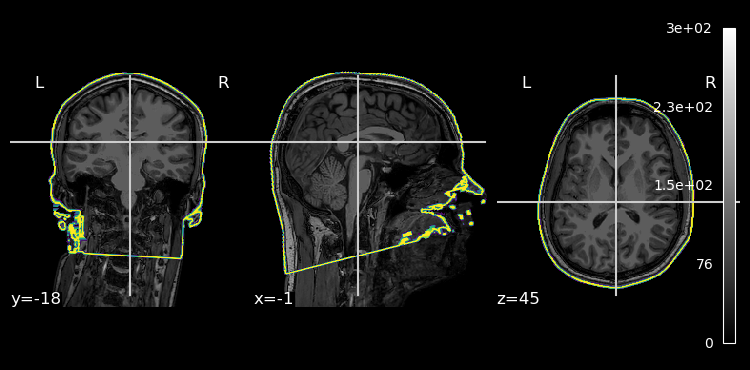

In [7]:
rhino.extract_surfaces(
    mri_file=f"BIDS/sub-{subject}/anat/sub-{subject}_T1w.nii.gz",
    outdir=f"BIDS/derivatives/anat_surfaces/sub-{subject}",
)

The above plots are:
1. The structural MRI
2. The inskull surface (yellow line).
3. The outskull surface (yellow line).
4. The outskin surface (yellow line).
5. The outskin surface including the nose (yellow line).

If these surfaces don't match the corresponding surface in the structural MRI, then these needs to be fixed before moving on. Alternatively, we can use a standard (MNI152) brain.

## OSL Output Files

Now we have the preprocessed sensor data and the MRI surfaces. We can perform an 'OSL' source reconstruction. This involves creating many files. Let's create an object (container) to keep track of all the files.

In [8]:
fns = utils.OSLFilenames(
    outdir="BIDS/derivatives/osl",
    id=id,
    preproc_file=f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif",
    surfaces_dir=f"BIDS/derivatives/anat_surfaces/sub-{subject}",
)
print(fns)

OSLFilenames for sub-05_ses-01_task-braille_run-01:
  Output directory:  BIDS/derivatives/osl
  Preprocessed file: BIDS/derivatives/preprocessed/sub-05_ses-01_task-braille_run-01_preproc-raw.fif
  Surfaces directory: BIDS/derivatives/anat_surfaces/sub-05
  BEM directory:     BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/bem
  Coreg directory:   BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg
    └─ Forward model: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/model-fwd.fif
  Source directory:  BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/src
    └─ lcmv filters:  BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/src/filters-lcmv.h5


There are some files which we have already generated like the preprocessed fif file and the surfaces. Other files we will create in the following steps.

Now let's extract the Polhemus from the preprocessed fif file and coregister the MEG and MRI.

## 3. Coregistration

Next we use the EinScan headshape points/fiducials to coregister the MEG and structural MRI.


Extracting fiducials/headshape points from fif info
---------------------------------------------------
Saved: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/head_nasion.txt
Saved: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/head_rpa.txt
Saved: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/head_lpa.txt
Saved: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/head_headshape.txt

Running coregistration (HEAD (polhemus) -> MRI)
-----------------------------------------------
The MRI-derived nose is going to be used to aid coregistration.
Please ensure that rhino.extract_surfaces was run with include_nose=True.
Please ensure that the headshape points include the nose.
Creating RawArray with float64 data, n_channels=219, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Overwriting existing file.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/info-ra

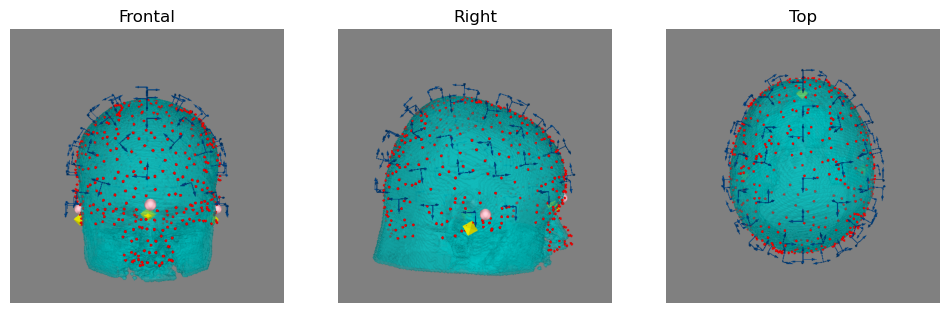

In [9]:
rhino.extract_fiducials_and_headshape_from_fif(fns)
rhino.coregister_head_and_mri(fns)

If the coregistration looks off we need to fix it before moving on. Some things we can try tweaking the headshape points and/or fiducials (these are in text files in `fns.coreg_dir`).

Next, we calculate the forward model for MEG. Here, we're using a 'Single Layer' (Single Shell) head model and a dipole grid resolution of 8mm.

In [10]:
rhino.forward_model(fns, model="Single Layer", gridstep=8)


Calculating forward model
-------------------------
Overwriting existing file.
Using bet_inskull_surf_file for single shell surface
Overwriting existing file.
Overwriting existing file.
Surface CM = (  -2.0  -20.2   40.2) mm
Surface fits inside a sphere with radius   94.1 mm
Surface extent:
    x =  -74.7 ...   65.7 mm
    y =  -96.0 ...   71.1 mm
    z =  -28.9 ...  102.8 mm
Grid extent:
    x =  -80.0 ...   72.0 mm
    y =  -96.0 ...   72.0 mm
    z =  -32.0 ...  104.0 mm
7920 sources before omitting any.
5964 sources after omitting infeasible sources not within 0.0 - 94.1 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    4.0 mm away (will take a few...)
Checking surface interior status for 5964 points...
    Found  278/5964 points inside  an interior sphere of radius   32.5 mm
    Found    0/5964 points outside an exterior sphere of radius   94.1 mm
    Found 2892/5686 points outside using surface Qhull
    Found  289/2794 po

## 4. Source Reconstruction

Now we are ready to create an LCMV beamformer. We will use a unit-noise-gain-invariant beamformer. Note, the rank of Elekta MEG data is <64 due to MaxFiltering.

In [11]:
source_recon.lcmv_beamformer(fns, raw, chantypes="mag", rank={"mag": 100})


Making LCMV beamformer
----------------------
Reading forward solution from /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (2342 sources, 192 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Using up to 6698 segments
Number of samples used : 306850
[done]
Variance for chantype mag is 2.603537517881003e-25
Excluding 27 channel(s) missing from the provided forward operator and/or covariance matrices
Computing rank from covariance with rank={'mag': 100}
Computing rank from covariance with rank='info'
    MAG: rank 188 after 0 projectors applied to 188 channels
Making LCMV beamformer with data cov rank {'mag': 100}
Making LCMV beamformer with noise cov rank {'mag': 188}
Computing invers

Next, we calculate voxel data by applying the beamformer weights to the sensor data. Note, the following function returns the voxel data  (and coordinates) in MNI space.

In [12]:
voxel_data, voxel_coords = source_recon.apply_lcmv_beamformer(fns, raw)


Applying LCMV beamformer
------------------------
Omitting 28000 of 334933 (8.36%) samples, retaining 306933 (91.64%) samples.
Reading forward solution from /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (2342 sources, 192 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
spatial_resolution = 8 mm
mask_file: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/src/MNI152_T1_8mm_brain.nii.gz
Finding nearest neighbour in resampled MNI space
Applying LCMV beamformer complete.


## 5. Parcellation

Now we have the voxel data, we can parcellate.

In [13]:
parcellation_file = "Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz"

parcel_data = parcellation.parcellate(
    fns,
    voxel_data,
    voxel_coords,
    method="spatial_basis",
    orthogonalisation="symmetric",
    parcellation_file=parcellation_file,
)

parc_fif = f"BIDS/derivatives/osl/{id}/lcmv-parc-raw.fif"
parcellation.save_as_fif(
    parcel_data,
    raw,
    extra_chans="stim",
    filename=parc_fif,
)


Parcellating data
-----------------
gridstep = 8 mm


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2026-01-19 20:08:28 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2026-01-19 20:08:28 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Resampled parcellation: BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/src/Glasser52_binary_space-MNI152NLin6_res-8x8x8_8mm.nii.gz
Finding nearest neighbour voxel
Calculating parcel time courses with spatial_basis
Performing symmetric orthogonalisation
Saving BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/lcmv-parc-raw.fif
Omitting 28000 of 334933 (8.36%) samples, retaining 306933 (91.64%) samples.
Creating RawArray with float64 data, n_channels=52, n_times=334933
    Range : 0 ... 334932 =      0.000 ...  1339.728 secs
Ready.
Creating RawArray with float64 data, n_channels=27, n_times=334933
    Range : 0 ... 334932 =      0.000 ...  1339.728 secs
Ready.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/lcmv-parc-raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/lcmv-parc-raw.fif
[done]


The final data is saved in the file `lcmv-parc-raw.fif`. The parcellated data is saves as a `'misc'` channel type.

The last thing we will do is plot the PSD of the parcel data to check the source reconstruction looks reasonable.

Opening raw data file BIDS/derivatives/osl/sub-05_ses-01_task-braille_run-01/lcmv-parc-raw.fif...
    Range : 0 ... 334932 =      0.000 ...  1339.728 secs
Ready.
Omitting 28000 of 334933 (8.36%) samples, retaining 306933 (91.64%) samples.


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2026-01-19 20:18:53 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


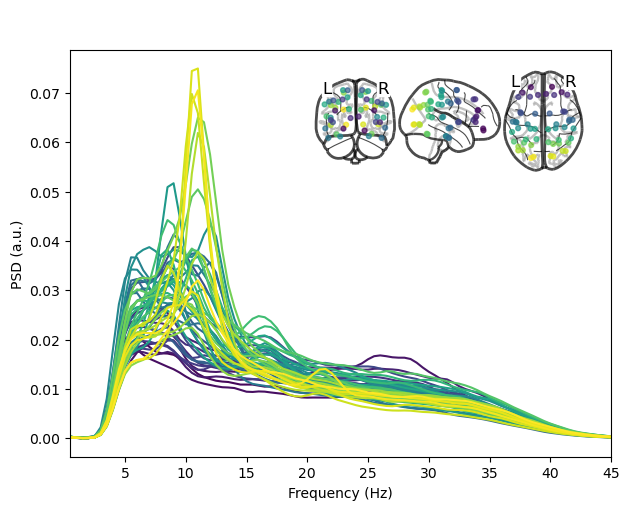

In [14]:
parcellation.plot_psds(parc_fif, parcellation_file=parcellation_file)

We should see alpha (~10 Hz) activity is posterior in the brain if not there may be an issue. Although note, there is a lot of subject variability, some subjects don't exhibit strong alpha oscillations.

## 6. Prepare Data for the Canonical HMM

Here, we prepare the data by aligning the sign of the parcel time courses to the template session from the canonical HMM and then perform time-delay embedding and PCA. Finally, we standardise the data. This is all done with the `prepare_data_for_canonical_hmm` function.

In [15]:
# Load and prepare the data
data = Data(parc_fif, picks="misc", reject_by_annotation="omit")
data = hmm.prepare_data_for_canonical_hmm(data, parcellation="52ROI_Glasser")

# Save
hmm_dir = f"BIDS/derivatives/hmm/{id}"
data.save(hmm_dir)

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating covariances:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-19 20:19:31 INFO osl-dynamics [base.py:1175:align_channel_signs]: Aligning channel signs across sessions
2026-01-19 20:20:16 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 0, best correlation with template: 0.115
2026-01-19 20:20:56 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 1, best correlation with template: 0.117
2026-01-19 20:21:36 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 2, best correlation with template: 0.124


TDE-PCA:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

Saving data:   0%|          | 0/1 [00:00<?, ?it/s]

## 7. Fit the Canonical HMM

First, we load a canonical HMM.

In [16]:
model = hmm.load_canonical_hmm(n_states=8, parcellation="52ROI_Glasser")
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 400, 120)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (8, 120)          │        960 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (8, 120, 120)     │     58,080 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 400, 120)  │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 400,      │         72 │ ll[0][0]          │
│ (HiddenMarkovState… │ 120), (None, 400, │            │                   │
│                     │ 8, 8)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ hid_state_inf[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,112 (230.91 KB)

 Trainable params: 58,152 (227.16 KB)

 Non-trainable params: 960 (3.75 KB)

Now let's infer the probability of each state being active at a given time point in the new data.

2026-01-19 20:21:44 INFO osl-dynamics [inf_mod_base.py:1151:get_alpha]: Getting alpha


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 942ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 796ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 995ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 782ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step  


2026-01-19 20:22:14.137619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-05_ses-01_task-braille_run-01/alp_raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-05_ses-01_task-braille_run-01/alp_raw.fif
[done]


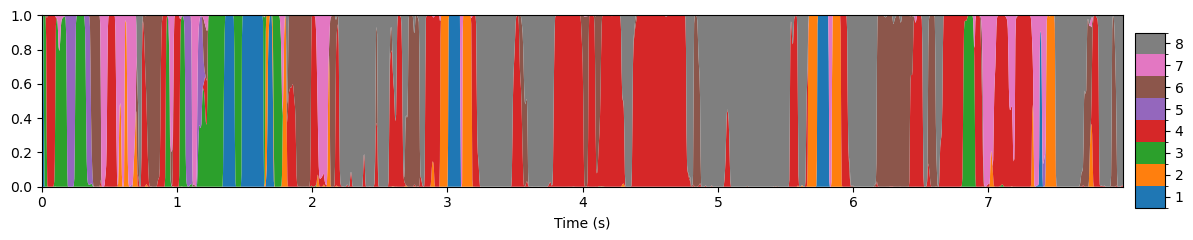

In [17]:
# State probability time course
alp = model.get_alpha(data)

# Save
alp_raw = inference.modes.convert_to_mne_raw(alp, parc_fif, n_embeddings=data.n_embeddings)
alp_raw.save(f"{hmm_dir}/alp_raw.fif", overwrite=True)

# Plot (just the first 8 seconds for visualisation)
fig, ax = plotting.plot_alpha(alp, n_samples=2000, sampling_frequency=250)

## 8. HMM Post-Hoc Analysis

Now we have the state probabilities, we can perform 'post-hoc analysis' where we estimate state-specific quantities of interest such as spectral properties, networks, and summary statistics for dynamics.

See the [osl-dynamics docs](https://osl-dynamics.readthedocs.io/en/latest/documentation.html) for further information and tutorials, as well as code for visualisations.

Let's start with the spectral properties.

In [18]:
# Calculate multitaper
trimmed_data = data.trim_time_series(sequence_length=model.config.sequence_length, prepared=False)
f, psd, coh = analysis.spectral.multitaper_spectra(
    data=trimmed_data,
    alpha=alp,
    sampling_frequency=250,
    frequency_range=[4, 40],
)
print(f.shape)
print(psd.shape)
print(coh.shape)

# Save
np.save(f"{hmm_dir}/f.npy", f)
np.save(f"{hmm_dir}/psd.npy", psd)
np.save(f"{hmm_dir}/coh.npy", coh)

2026-01-19 20:22:20 INFO osl-dynamics [spectral.py:478:multitaper_spectra]: Calculating spectra


(73,)
(8, 52, 73)
(8, 52, 52, 73)


Now let's use the spectra to calculate state-specific networks.

In [19]:
# Power maps
pow_maps = analysis.power.variance_from_spectra(f, psd)
print(pow_maps.shape)
np.save(f"{hmm_dir}/pow_maps.npy", pow_maps)

# Coherence networks
coh_nets = analysis.connectivity.mean_coherence_from_spectra(f, coh)
print(coh_nets.shape)
np.save(f"{hmm_dir}/coh_nets.npy", coh_nets)

(8, 52)
(8, 52, 52)


Finally, let's calculate summary statistics for dynamics.

In [20]:
# Binarise the state probabilities
stc = inference.modes.argmax_time_courses(alp)

# Summary statistics
fo = analysis.post_hoc.fractional_occupancies(stc)
lt = analysis.post_hoc.mean_lifetimes(stc, sampling_frequency=250)
intv = analysis.post_hoc.mean_intervals(stc, sampling_frequency=250)
sr = analysis.post_hoc.switching_rates(stc, sampling_frequency=250)

# Save
np.save(f"{hmm_dir}/fo.npy", fo)
np.save(f"{hmm_dir}/lt.npy", lt)
np.save(f"{hmm_dir}/intv.npy", intv)
np.save(f"{hmm_dir}/sr.npy", sr)